## 1

**Summarize for us the goal of this project and how machine learning is useful in trying to accomplish it. As part of your answer, give some background on the dataset and how it can be used to answer the project question. Were there any outliers in the data when you got it, and how did you handle those?**

The goal of this project is to train a supervised machine learning algorithm for prediction.  To do this, we'll be using the Enron data set.  This data set contains financial information and email data from various employees in that former company.  Enron was an energy commodities and services corporation that went bankrupt in 2001 due to fraud.  The supervised model will attempt to classify whether or not an employee was a person of interest (ie whether or not they were complicit).

In [1]:
#!/usr/bin/python
# -*- coding: utf-8 -*-
import pickle

In [2]:
### Task 1: Select what features you'll use.
### features_list is a list of strings, each of which is a feature name.
### The first feature must be "poi".

financial_features = ['salary', 'deferral_payments', 'total_payments',
'loan_advances', 'bonus', 'restricted_stock_deferred', 'deferred_income',
'total_stock_value', 'expenses', 'exercised_stock_options', 'other',
'long_term_incentive', 'restricted_stock', 'director_fees']
# all units in USD
email_features = ['to_messages', 'from_poi_to_this_person', 'email_address',
'from_messages', 'from_this_person_to_poi', 'shared_receipt_with_poi']
# email_address only non-numeric
poi_label = ['poi'] # boolean
# include all features to start
features_list = poi_label + financial_features + email_features

### Load the dictionary containing the dataset
with open("final_project_dataset.pkl", "r") as data_file:
    data_dict = pickle.load(data_file)

In [3]:
### Task 2: Remove outliers

import pandas as pd
import numpy as np

df = pd.DataFrame.from_dict(data_dict, orient = 'index')
#print df.isnull().any()
# NaN values are actually strings
df = df.replace('NaN', np.nan) # works better than '0' for stats/plots
# general data set information
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 146 entries, ALLEN PHILLIP K to YEAP SOON
Data columns (total 21 columns):
salary                       95 non-null float64
to_messages                  86 non-null float64
deferral_payments            39 non-null float64
total_payments               125 non-null float64
exercised_stock_options      102 non-null float64
bonus                        82 non-null float64
restricted_stock             110 non-null float64
shared_receipt_with_poi      86 non-null float64
restricted_stock_deferred    18 non-null float64
total_stock_value            126 non-null float64
expenses                     95 non-null float64
loan_advances                4 non-null float64
from_messages                86 non-null float64
other                        93 non-null float64
from_this_person_to_poi      86 non-null float64
poi                          146 non-null bool
director_fees                17 non-null float64
deferred_income              49 non-null float

In [4]:
# number of POIs
sum(df.poi == True)

18

There are 146 observations (people) in the data set and a total of 21 features.  Out of 146 people, 18 are persons of interest.  Some features have more missing values than others.  Below is the percentage of missing values in each feature.

In [5]:
100* df.isnull().sum() / df.shape[0]

salary                       34.931507
to_messages                  41.095890
deferral_payments            73.287671
total_payments               14.383562
exercised_stock_options      30.136986
bonus                        43.835616
restricted_stock             24.657534
shared_receipt_with_poi      41.095890
restricted_stock_deferred    87.671233
total_stock_value            13.698630
expenses                     34.931507
loan_advances                97.260274
from_messages                41.095890
other                        36.301370
from_this_person_to_poi      41.095890
poi                           0.000000
director_fees                88.356164
deferred_income              66.438356
long_term_incentive          54.794521
email_address                23.972603
from_poi_to_this_person      41.095890
dtype: float64

There are a few features that have more than 50% missing data and might be worthwhile to exclude:

- loan_advances
- director_fees
- restricted_stock_deferred
- deferral_payments
- deferred_income
- long_term_incentive

In [6]:
missing_data = ['loan_advances', 'director_fees', 'restricted_stock_deferred',\
               'deferral_payments', 'deferred_income', 'long_term_incentive']
# number of NaN for POIs in missing data features
df[df.poi == True][missing_data].isnull().sum()

loan_advances                17
director_fees                18
restricted_stock_deferred    18
deferral_payments            13
deferred_income               7
long_term_incentive           6
dtype: int64

Loan advances, director fees, and restricted stock deferred will be removed since they have little to no data for POIs.

In [7]:
remove = ['loan_advances', 'director_fees', 'restricted_stock_deferred']
features_list = [feat for feat in features_list if feat not in remove]

After looking over the `insiderpay.pdf` file, I decided to remove `THE TRAVEL AGENCY IN THE PARK` observation (not a person).

In [8]:
df = df.drop('THE TRAVEL AGENCY IN THE PARK')

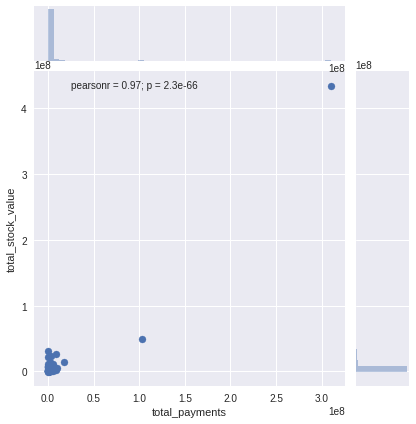

In [9]:
import seaborn as sns
%matplotlib inline
# if NaN strings are kept, need to filter these values
#df_plt = df[(df.total_payments != "NaN") & (df.total_stock_value != "NaN")]

# total payments vs total stock value
sns.jointplot(x="total_payments", y="total_stock_value", data=df, dropna=True)
sns.plt.show()

In [10]:
df[df.total_payments > 1e8].index

Index([u'LAY KENNETH L', u'TOTAL'], dtype='object')

In [11]:
df.total_payments.idxmax()

'TOTAL'

There are 2 significant outliers in the data.  The first and largest is `TOTAL` which is simply the sum of all observations, so this will be removed.  The other is Ken Lay, who was the CEO of Enron and a definite POI in the data.  Ken Lay will be kept, especially since there are few POIs to begin with.

In [12]:
df = df.drop('TOTAL')

In [13]:
# people with no financial data
df[df[financial_features].isnull().all(axis=1)].index

Index([u'LOCKHART EUGENE E'], dtype='object')

There is 1 person without any financial data that will also need to be removed.

In [14]:
df = df.drop('LOCKHART EUGENE E')

I've also decided to leave out some of the numerical email features.  Those that are from/to POI messages contain information about who and who is not a POI (ie data leakage).

In [15]:
leakage = ['from_this_person_to_poi', 'from_poi_to_this_person', 'shared_receipt_with_poi']
features_list = [feat for feat in features_list if feat not in leakage]

To get an idea for what type of benchmark classifier to use, I want to see if the data looks remotely linearly separable (ie logistic regression or tree based/other).

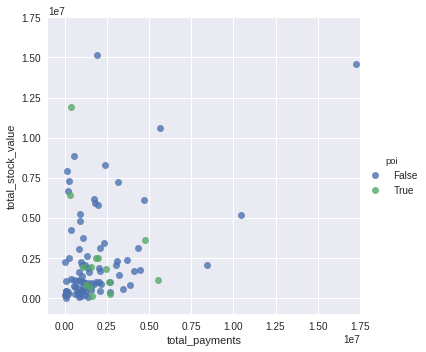

In [16]:
p = sns.lmplot('total_payments', 'total_stock_value', data=df, hue='poi', fit_reg=False)
p.set(xlim=(-1e6, 1.75e7), ylim=(-1e6, 1.75e7))
sns.plt.show()

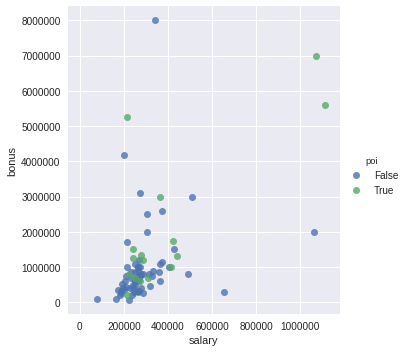

In [17]:
sns.lmplot('salary', 'bonus', data=df, hue='poi', fit_reg=False)
sns.plt.show()

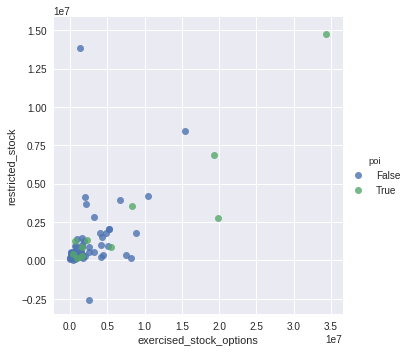

In [18]:
sns.lmplot('exercised_stock_options', 'restricted_stock', data=df, hue='poi', fit_reg=False)
sns.plt.show()

Not an exhaustive search (pairs plot function in seaborn can't handle NaN values) but I don't think a logistic regression is the best choice for a benchmark classifier.  I'll try naive bayes or decision tree...

In [19]:
# dataframe back to dictionary
df = df.replace(np.nan, 'NaN') # need to convert back to 'NaN' 
data_dict = df[features_list].to_dict(orient = 'index')

In [20]:
from benchmark import benchmark_score
benchmark_score(data_dict, features_list)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=None, splitter='best')
	Accuracy: 0.79827	Precision: 0.24012	Recall: 0.23700	F1: 0.23855	F2: 0.23762
	Total predictions: 15000	True positives:  474	False positives: 1500	False negatives: 1526	True negatives: 11500



In [21]:
# dump to pickle for checkpoint
with open("outlier_dataset.pkl", "w") as f_out:
    pickle.dump(data_dict, f_out)

## 2

**What features did you end up using in your POI identifier, and what selection process did you use to pick them? Did you have to do any scaling? Why or why not? As part of the assignment, you should attempt to engineer your own feature that does not come ready-made in the dataset -- explain what feature you tried to make, and the rationale behind it. (You do not necessarily have to use it in the final analysis, only engineer and test it.) In your feature selection step, if you used an algorithm like a decision tree, please also give the feature importances of the features that you use, and if you used an automated feature selection function like SelectKBest, please report the feature scores and reasons for your choice of parameter values.**

During the data exploration and outlier removal process, I found some features with a large proportion of missing values.  There were also email features that incorporated information about POI status.  So these were all excluded from the features list:

- loan_advances
- director_fees
- restricted_stock_deferred
- from_this_person_to_poi
- from_poi_to_this_person

I created a few new features from the email corpus.  This was a pretty lengthy procedure.

I first had to perform an audit to be that sure people who had email addresses and numerical email data, in fact had email text data (see `audit_emails.py`).  Then I built an email corpus for each person of all to and from emails, while cleaning the text data in the process (see `build_email_corpus.py`).

In [42]:
### Task 3: Create new feature(s)
### Store to my_dataset for easy export below.

with open("outlier_dataset.pkl", "r") as f_in:
        data_dict = pickle.load(f_in)

In [20]:
from build_email_corpus import build_email_dataset
build_email_dataset(data_dict)

0 paths not found
time to build corpus: 86.95 minutes


At this point each person had a new feature.  The feature is a list where every element in the list is the text for a single email.  There were too many emails to try a bag-of-words approach.  I actually tried both a count vectorizer as well as TfIdf (term frequency inverse document frequency) but the dimensionality of terms was too great.

I decided to reduce the dimensionality of the email corpus for each person using LDA (latent dirichlet allocation).  The emails for each person were then reduced to just a few topics and all topics were limited in the size of vocabulary (see `build_topic_corpus.py`).

In [24]:
with open("emails_dataset.pkl", "r") as f_in:
        data_dict = pickle.load(f_in)

In [25]:
from build_topic_corpus import build_topic_dataset
build_topic_dataset(data_dict)

time to build topics: 11.51 minutes


From here I used a random forest classifer with cross validation to extract words with predictive capability (see `create_word_features.py`).  The end result is that each person was given 10 new numerical features.  The feature name is the (hopefully) meaningful word and the value is the number of times that word occurred in that person's topic corpus.

In [27]:
with open("topic_dataset.pkl", "r") as f_in:
        data_dict = pickle.load(f_in)

In [28]:
from create_word_features import build_word_dataset
build_word_dataset(data_dict)

In [52]:
# final checkpoint
with open("word_dataset.pkl", "r") as f_in:
        data_dict = pickle.load(f_in)

With new features added, see if they have improved the benchmark score.

In [53]:
df = pd.DataFrame.from_dict(data_dict, orient = 'index')
all_features = df.columns.values.tolist()

In [54]:
from benchmark import benchmark_score
benchmark_score(data_dict, all_features)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=None, splitter='best')
	Accuracy: 0.82407	Precision: 0.34936	Recall: 0.37050	F1: 0.35962	F2: 0.36607
	Total predictions: 15000	True positives:  741	False positives: 1380	False negatives: 1259	True negatives: 11620



including the new features defintely improved the score...

feature selection method, feature importances from decision tree classifier used on stratified folds of data...

In [55]:
from feature_selector import get_feature_scores
names, scores = get_feature_scores(data_dict)

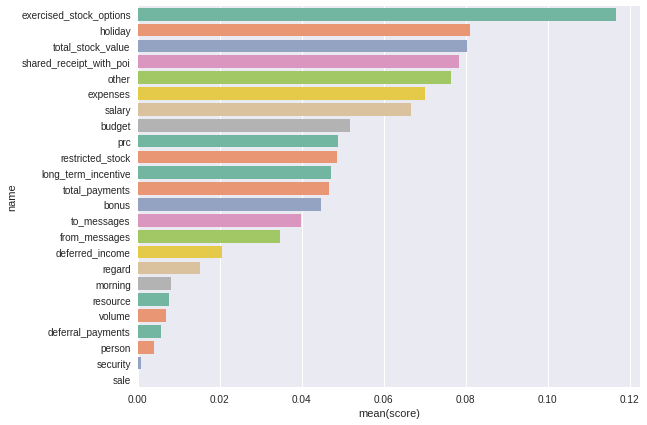

In [56]:
# plot names with scores
import matplotlib.pyplot as plt
df_plt = pd.DataFrame()
df_plt['name'] = names; df_plt['score'] = scores
fig, ax = plt.subplots()
fig.set_size_inches(9, 7)
sns.barplot(y = "name", x = "score", data = df_plt,
            palette = sns.color_palette("Set2", 10))
sns.plt.show()

arbitrary cutoff after 0.06, keep
- bonus
- exercised stock options
- expenses
- holiday (email data was useful)
- other
- restricted stock
- total stock value

score after reducing features...

In [57]:
reduced_features = ['poi'] + names[0:7]

In [58]:
# after reducing features
benchmark_score(data_dict, reduced_features)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=None, splitter='best')
	Accuracy: 0.84000	Precision: 0.44118	Recall: 0.45000	F1: 0.44554	F2: 0.44821
	Total predictions: 14000	True positives:  900	False positives: 1140	False negatives: 1100	True negatives: 10860



score improved, can say that these features capture signal in POIs while removing some noise...

In [75]:
sum(df.holiday != 0)

9

there are 9 people who have the word 'holiday' in their topic text, so at least this word isn't exclusive to just 1 or 2 people.

## 3

**What algorithm did you end up using? What other one(s) did you try? How did model performance differ between algorithms?**

In [30]:
### Task 4: Try a variety of classifiers
### Please name your classifier clf for easy export below.
### Note that if you want to do PCA or other multi-stage operations,
### you'll need to use Pipelines. For more info:
### http://scikit-learn.org/stable/modules/pipeline.html

import sys
sys.path.append("../tools/") # path for 'feature_format.py'
from feature_format import featureFormat, targetFeatureSplit
from tester import dump_classifier_and_data, test_classifier
# format for model testing
data = featureFormat(data_dict, reduced_features, sort_keys = True)
labels, features = targetFeatureSplit(data)

In [33]:
### Task 5: Tune your classifier to achieve better than .3 precision and recall 
### using our testing script. Check the tester.py script in the final project
### folder for details on the evaluation method, especially the test_classifier
### function. Because of the small size of the dataset, the script uses
### stratified shuffle split cross validation. For more info: 
### http://scikit-learn.org/stable/modules/generated/sklearn.cross_validation.StratifiedShuffleSplit.html

from sklearn.model_selection import RandomizedSearchCV

In [41]:
# naive bayes
from sklearn.naive_bayes import GaussianNB

gnb = GaussianNB()
test_classifier(gnb, data_dict, reduced_features)

GaussianNB(priors=None)
	Accuracy: 0.84171	Precision: 0.42082	Recall: 0.28700	F1: 0.34126	F2: 0.30649
	Total predictions: 14000	True positives:  574	False positives:  790	False negatives: 1426	True negatives: 11210



In [45]:
# knn
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

estimators = [('scaler', StandardScaler()),
              ('knn', KNeighborsClassifier())]
knn_params = dict(knn__n_neighbors = list(range(1, 10)),
                  knn__weights = ['uniform', 'distance'])
pipe = Pipeline(estimators)
# 'cv' param is num folds for stratified K fold
knn_srch = RandomizedSearchCV(pipe, cv = 10, param_distributions = knn_params,
                              scoring = 'recall', verbose = 1)
knn_srch.fit(features, labels)
# best estimator
knn = knn_srch.best_estimator_
test_classifier(knn, data_dict, reduced_features)

Fitting 10 folds for each of 10 candidates, totalling 100 fits


[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.8s finished


Pipeline(steps=[('scaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('knn', KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=4, p=2,
           weights='distance'))])
	Accuracy: 0.89793	Precision: 0.86744	Recall: 0.33700	F1: 0.48542	F2: 0.38396
	Total predictions: 14000	True positives:  674	False positives:  103	False negatives: 1326	True negatives: 11897



In [47]:
# support vector machine
from sklearn.svm import SVC

estimators = [('scaler', StandardScaler()),
              ('svc', SVC())]
svc_params = dict(svc__C = [x/10.0 for x in range(1, 10)],
                  svc__kernel = ['poly', 'rbf', 'sigmoid'])
pipe = Pipeline(estimators)

svc_srch = RandomizedSearchCV(pipe, cv = 10, param_distributions = svc_params, scoring = 'recall', verbose = 1)
svc_srch.fit(features, labels)
svc = svc_srch.best_estimator_
test_classifier(svc, data_dict, reduced_features)

Fitting 10 folds for each of 10 candidates, totalling 100 fits


[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.8s finished


Pipeline(steps=[('scaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('svc', SVC(C=0.8, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape=None, degree=3, gamma='auto', kernel='poly',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False))])
	Accuracy: 0.88443	Precision: 0.75000	Recall: 0.28650	F1: 0.41462	F2: 0.32691
	Total predictions: 14000	True positives:  573	False positives:  191	False negatives: 1427	True negatives: 11809



In [48]:
# random forest
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier()
rf_params = dict(n_estimators = list(range(10, 40, 5)),
                 max_depth = list(range(2, 10)))

rf_srch = RandomizedSearchCV(rf, param_distributions = rf_params,
                             cv = 10, scoring = 'recall', verbose = 1)
rf_srch.fit(features, labels)
rf = rf_srch.best_estimator_
test_classifier(rf, data_dict, reduced_features)

Fitting 10 folds for each of 10 candidates, totalling 100 fits


[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    9.4s finished


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=8, max_features='auto', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=35, n_jobs=1, oob_score=False, random_state=None,
            verbose=0, warm_start=False)
	Accuracy: 0.89171	Precision: 0.74544	Recall: 0.36750	F1: 0.49230	F2: 0.40897
	Total predictions: 14000	True positives:  735	False positives:  251	False negatives: 1265	True negatives: 11749



In [40]:
# adaboost
from sklearn.ensemble import AdaBoostClassifier

ada = AdaBoostClassifier()
ada_params = dict(learning_rate=[x/20.0 for x in range(1, 20)])
ada_srch = RandomizedSearchCV(ada, param_distributions = ada_params,
                              cv = 10, scoring = 'recall', verbose = 1)
ada_srch.fit(features, labels)
ada = ada_srch.best_estimator_
test_classifier(ada, data_dict, reduced_features)

Fitting 10 folds for each of 10 candidates, totalling 100 fits


[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:   13.2s finished


AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None,
          learning_rate=0.1, n_estimators=50, random_state=None)
	Accuracy: 0.88943	Precision: 0.69024	Recall: 0.41000	F1: 0.51443	F2: 0.44623
	Total predictions: 14000	True positives:  820	False positives:  368	False negatives: 1180	True negatives: 11632



I tried several different classifiers:

- gaussian naive bayes
- k-nearest neighbors
- support vector machine
- random forest
- adaboost

these were the most promising in terms of picking up on non-linear associations in the data.  The accuracy didn't change too much across classifiers with the exception of the naive bayes algorithm which had the lowest.  I ended up with really high precision scores for k-nearest neighbors, the support vector classifier, and random forest.  Unfortunately the recall scores for these weren't as high.  The F1 score was highest for the adaboost classifier offering the best balance of both precision and recall.  I settled on this form my final classifier.

In [49]:
### Task 6: Dump your classifier, dataset, and features_list so anyone can
### check your results. You do not need to change anything below, but make sure
### that the version of poi_id.py that you submit can be run on its own and
### generates the necessary .pkl files for validating your results.

dump_classifier_and_data(ada, data_dict, reduced_features)

## 4

**What does it mean to tune the parameters of an algorithm, and what can happen if you don’t do this well?  How did you tune the parameters of your particular algorithm? (Some algorithms do not have parameters that you need to tune -- if this is the case for the one you picked, identify and briefly explain how you would have done it for the model that was not your final choice or a different model that does utilize parameter tuning, e.g. a decision tree classifier)**

Parameter tuning is an important part of the model building process.  It involves adjusting an algorithms internal 'machinery' or hyperparameters so that it can be optimized for the task at hand.  In some cases an algorithm can be very sensitive to the nature of the data, and only certain hyperparameter values will allow the model to perform well.  In other cases, the model may perform fairly well without tuning, but it can perform even better with it.  It's also possible to enhance an algorithm so that it maximizes a particular evaluation metric (as with 'recall' above).

The naive bayes classifier was the only algorithm without any hyperparameters.  You can set the priors but it's best to let the algorithm figure that out based upon the data.  In order to find optimal hyperparameters for the other models I tested, I used a randomized grid search which was set to increase the recall score.  Randomization is quicker than a typical grid search and has been shown to be just as good at finding the best parameter settings.  The random search used a stratified k-fold (set to 10) cross validation so that test and train subset were balanced over the target POI class.  The adaboost classifier, which was my final model, achieved it's best score with a learning rate of 0.10.  So any values larger than this may not have allowed the algorithm to converge to a local/global minimum for the loss function, while smaller values did not reach a minimum with the given amount of iterations.

## 5

**What is validation, and what’s a classic mistake you can make if you do it wrong? How did you validate your analysis?**

Validation is the process of estimating the model's performance on unseen data.  It prevents us from overfitting on training data while selecting features and building the model.  It's important to get an idea for how the model will generalize to new data.  A model that is overfit and does not perform well on new data is pretty much useless.

To validate all of the tested models, I used a stratified shuffle split cross validation.  Stratification of folds in a cross-validation ensure that each test and train set have a balanced proportion of the target class.  So each test and train fold in this context will have roughly the same ratio of POIs to non-POIs.  This is important as an imbalance can give unrealistic evaluation metrics.  The shuffle split ensures randomization across folds and in such a way that folds are not continuous chunks of data (ie indices are mixed up).

## 6

**Give at least 2 evaluation metrics and your average performance for each of them.  Explain an interpretation of your metrics that says something human-understandable about your algorithm’s performance. **

The final adaboost classifier achieved an accuracy of 0.89 with precision and recall scores of 0.69 and 0.41.  Accuracy is simply the ratio of true predictions over total predictions.  This means that 89% of the time, the adaboost classifier correctly identified a person as POI or non-POI.  This is actually a poor metric for this data set because of the few number of POIs.  If you were to guess that all people were non-POIs, you would achieve an accuracy of (146 - 18)/146 = 87%.  So although this seems like a high accuracy score, it's not much better than assuming nobody is a POI.

This is why recall and precision are much better metrics.  The precision score for the adaboost classifier means that when the algorithm labeled a person as a POI, 69% percent of the time they were.  This also means that 31% of people were incorrectly identified as POIs.  When the algorithm was evaluating a POI, 41% of the time they would be correctly labeled, which is the recall.  So about 59% of POIs 'got away' from the classifier.